This competition was a fantastic journey for me and my teammate. Mostly, we learned the importance of selecting right Cross Validation strategy. I will share our approach (mostly we utilized kagglers' code). If I forget to mention you or your kernel, it's not on purpose. Please warn me on comments. Hope you will like it!

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
# Standard plotly imports



# Preprocessing, modelling and evaluating
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm as lgb

import os
import gc

# Reading and Merging Identity and Transaction Datasets

In [2]:
train_identity = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
sub = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

Fraud data is usually imbalanced. Let's check how this one is.

In [3]:
train.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

The data that we are working on is imbalanced. There are many ways to deal with imbalanced data. Me and my teammate decided to use undersampling the majority class. And, we would like to thank Shahules786 for this very informative kernel. You can check his kernel [here](https://www.kaggle.com/shahules/tackling-class-imbalance). And, don't forget to upvote. We decided do downsample majority class to 400k. We decided it by trial and error.

In [4]:
from sklearn.utils import resample
not_fraud=train[train.isFraud==0]
fraud=train[train.isFraud==1]

not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = 400000, # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.isFraud.value_counts()

0    400000
1     20663
Name: isFraud, dtype: int64

In [5]:
train = downsampled.copy()
del not_fraud_downsampled, downsampled, train_identity, test_identity, train_transaction, test_transaction

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

NameError: name 'reduce_mem_usage' is not defined

The functions which are named as setBrowser, setDevice and setTimer are taken from this amazing [kernel](https://www.kaggle.com/tolgahancepel/lightgbm-single-model-and-feature-engineering). Go and upvote him!

In [8]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

In [9]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].cat.add_categories('unknown_device')
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    #df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

In [10]:
from tqdm import tqdm_notebook
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

### Combining Two or More Columns

Two (string or numeric) columns can be combined into one column. If you think that you should improve your feature engineering skills, you definitely should check this [discussion topic](https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-643395). Chris is an amazing Kaggler.

In [11]:
train['d2_d4_comb'] = train['D2'].astype(str)+ '_' +train['D4'].astype(str)
test['d2_d4_comb'] = test['D2'].astype(str)+ '_' +test['D4'].astype(str)

In [12]:
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)
    
    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

### Creating unique IDs by combining two columns

In [13]:
def uid_fe(df):
    df['uid'] = df['card1'].astype(str)+'_'+df['card2'].astype(str)
    df['uid2'] = df['uid'].astype(str)+'_'+df['card3'].astype(str)+'_'+df['card5'].astype(str)
    df['uid3'] = df['uid2'].astype(str)+'_'+df['addr1'].astype(str)+'_'+df['addr2'].astype(str)
    df['uid4'] = df['uid3'].astype(str)+'_'+df['P_emaildomain'].astype(str)
    df['uid5'] = df['uid3'].astype(str)+'_'+df['R_emaildomain'].astype(str)
    return df
train = uid_fe(train)
test = uid_fe(test)

# Feature Engineering with GroupBy

The code and features down below belongs to Andrew Lukyanenko. Thanks for his amazing kernel. And down forget to upvote his kernel [here](https://www.kaggle.com/artgor/eda-and-models).

In [14]:
def andrew_fe(df):
    df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
    df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')

    df['id_02_to_mean_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('mean')
    df['id_02_to_mean_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('mean')
    df['id_02_to_std_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('std')
    df['id_02_to_std_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('std')

    df['D15_to_mean_card1'] = train['D15'] / df.groupby(['card1'])['D15'].transform('mean')
    df['D15_to_mean_card4'] = train['D15'] / df.groupby(['card4'])['D15'].transform('mean')
    df['D15_to_std_card1'] = train['D15'] / df.groupby(['card1'])['D15'].transform('std')
    df['D15_to_std_card4'] = train['D15'] / df.groupby(['card4'])['D15'].transform('std')

    df['D15_to_mean_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('mean')
    df['D15_to_mean_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('mean')
    df['D15_to_std_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('std')
    df['D15_to_std_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('std')
    return df

train = andrew_fe(train)
test = andrew_fe(test)

## Feature Engineering Based on ProductCD

ProductCD is one of the most important features in this dataset. Let's check it. The code below belongs to this extensive [kernel](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt). Please, go and upvote it!

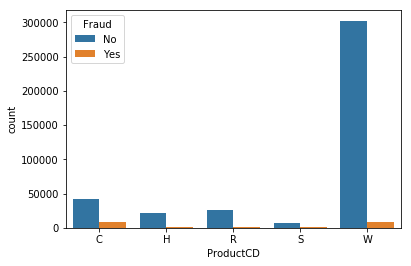

In [15]:
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [16]:
def product_fe(df):
    df["card1_count"] = df.groupby(["card1"])["ProductCD"].transform("size")
    df["card2_count"] = df.groupby(["card2"])["ProductCD"].transform("size")
    df["card5_count"] = df.groupby(["card5"])["ProductCD"].transform("size")
    df["R_email_count"] = df.groupby(["R_emaildomain"])["ProductCD"].transform("size")
    df["P_email_count"] = df.groupby(["P_emaildomain"])["ProductCD"].transform("size")
    df["P_R_emails_count"] = df.groupby(["P_emaildomain","R_emaildomain"])["ProductCD"].transform("size")
    df["addr1_count"] = df.groupby(["addr1"])["ProductCD"].transform("size")
    df["addr2_count"] = df.groupby(["addr2"])["ProductCD"].transform("size")
    df["joint_addr1_card1_count"] = df.groupby(["addr1","card1"])["ProductCD"].transform("size") #our MAGICAL FEATURE
    df["joint_matches_count"] = df.groupby(["M4","M5", "M6"])["ProductCD"].transform("size")
    df["joint_d2_d4_count"] = df.groupby(['d2_d4_comb'])["ProductCD"].transform("size")
    df["joint_card1_d2_d4_count"] = df.groupby(["card1","d2_d4_comb"])["ProductCD"].transform("size")
    df["uid_pd5_count"] = df.groupby(["uid5"])["ProductCD"].transform("size")
    df["uid_pd5_count"] = df.groupby(["uid5"])["ProductCD"].transform("size")
    
    return df

train = product_fe(train)
test = product_fe(test)

## New Features with Transaction Amounts' Decimal Part with GroupBy

In [17]:
def decimal_fe(df):
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)
    df['TransactionAmt_decimal_to_mean_card1'] = df['TransactionAmt_decimal'] / train.groupby(['card1'])['TransactionAmt_decimal'].transform('mean')
    df['TransactionAmt_decimal_to_mean_card2'] = df['TransactionAmt_decimal'] / train.groupby(['card2'])['TransactionAmt_decimal'].transform('mean')
    df['TransactionAmt_decimal_to_mean_card4'] = df['TransactionAmt_decimal'] / train.groupby(['card4'])['TransactionAmt_decimal'].transform('mean')
    df['TransactionAmt_decimal_to_std_card1'] = df['TransactionAmt_decimal'] / train.groupby(['card1'])['TransactionAmt_decimal'].transform('std')
    df['TransactionAmt_decimal_to_std_card2'] = df['TransactionAmt_decimal'] / train.groupby(['card2'])['TransactionAmt_decimal'].transform('std')
    df['TransactionAmt_decimal_to_std_card4'] = df['TransactionAmt_decimal'] / train.groupby(['card4'])['TransactionAmt_decimal'].transform('std')
    
    return df

train = decimal_fe(train)
test = decimal_fe(test)


After doing some tests, we found out that TransactionAmt_decimal column was increasing the gap between training and validation set. But the features that are made with this column was useful. Thus, we decided to stick with the new features and remove the TransactionAmt_decimal column itself.

In [18]:
train.drop(labels=['TransactionAmt_decimal'],axis=1,inplace=True)
test.drop(labels=['TransactionAmt_decimal'],axis=1,inplace=True)

### New Features with E-Mail Domains

In [19]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [20]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

## Some Frequency Encoding and GroupBy for Transaction Day of the Week, Transaction Hour and Unique IDs.

In [21]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [22]:
def setTime(df):
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day

    df['TransactionAmt_to_mean_hour'] = df['TransactionAmt'] / df.groupby(['DT_hour'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_mean_dow'] = df['TransactionAmt'] / df.groupby(['DT_day_week'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_std_dow'] = df['TransactionAmt'] / df.groupby(['DT_day_week'])['TransactionAmt'].transform('std')
    df['TransactionAmt_to_std_hour'] = df['TransactionAmt'] / df.groupby(['DT_hour'])['TransactionAmt'].transform('std')
    return df
train = setTime(train)
test= setTime(test)

In [23]:
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)

In [24]:
periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [25]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo',
          'id_30','id_33',
          'uid','uid2','uid3','uid4','uid5'
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)

In [26]:
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train, test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)

In [27]:
for col in ['ProductCD','M4']:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean'] = test[col].map(temp_dict)

## Count Encoding for Training and Test Set

In [28]:
# Encoding - count encoding for both train and test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

In [29]:
#After some tests, we decided to drop uid column since it increases the gap between training and validation.
train.drop(labels=['uid'],axis=1,inplace=True)
test.drop(labels=['uid'],axis=1,inplace=True)

In [30]:
for feature in ['d2_d4_comb', 'uid2', 'uid3', 'uid4', 'uid5', 'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix']:

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [31]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'DT','TransactionDT','TransactionID'], axis=1)
Y = train.sort_values('TransactionDT')['isFraud']
X_test = test.drop(['TransactionDT', 'DT','TransactionID'], axis=1)

In [32]:
del train, test

While we were testing our new features with the given parameters below, we decided to play with max_depth a bit to see if we are overfitting. We changed it as 3, and the difference between validation and training were decreased. It might be a good idea to optimize it. But in my opinion, optimizing it at the last day of the competition was our biggest mistake. Changing max depth parameter caused underfitting and huge shakeup.

In [33]:
params = {'num_leaves': 493,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [34]:
import datetime
from time import time
from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold
folds = StratifiedKFold(n_splits=5)

evals_result = {}
trainings = list()
aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, Y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=Y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=Y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500, evals_result=evals_result)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    trainings.append(clf.best_score['training']['auc'])

    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('STD AUC:', np.std(aucs))
print('Training AUC:', np.mean(trainings))
print('Difference is:', np.mean(trainings)-np.mean(aucs))
print('-' * 30)

Training on fold 1


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999543	valid_1's auc: 0.913651
[2000]	training's auc: 1	valid_1's auc: 0.911362
Early stopping, best iteration is:
[1504]	training's auc: 0.999988	valid_1's auc: 0.918712
Fold 1 finished in 0:22:58.307387
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[225]	training's auc: 0.968512	valid_1's auc: 0.90677
Fold 2 finished in 0:08:20.772188
Training on fold 3
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[436]	training's auc: 0.987502	valid_1's auc: 0.921246
Fold 3 finished in 0:11:03.058327
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999379	valid_1's auc: 0.951423
Early stopping, best iteration is:
[912]	training's auc: 0.998929	valid_1's auc: 0.95143
Fold 4 finished in 0:16:08.027994
Training on fold 5
Training until v

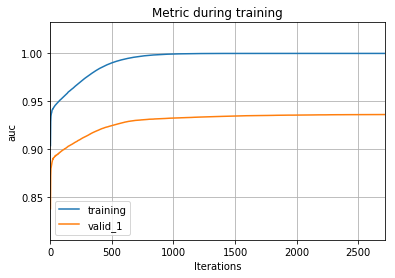

In [35]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

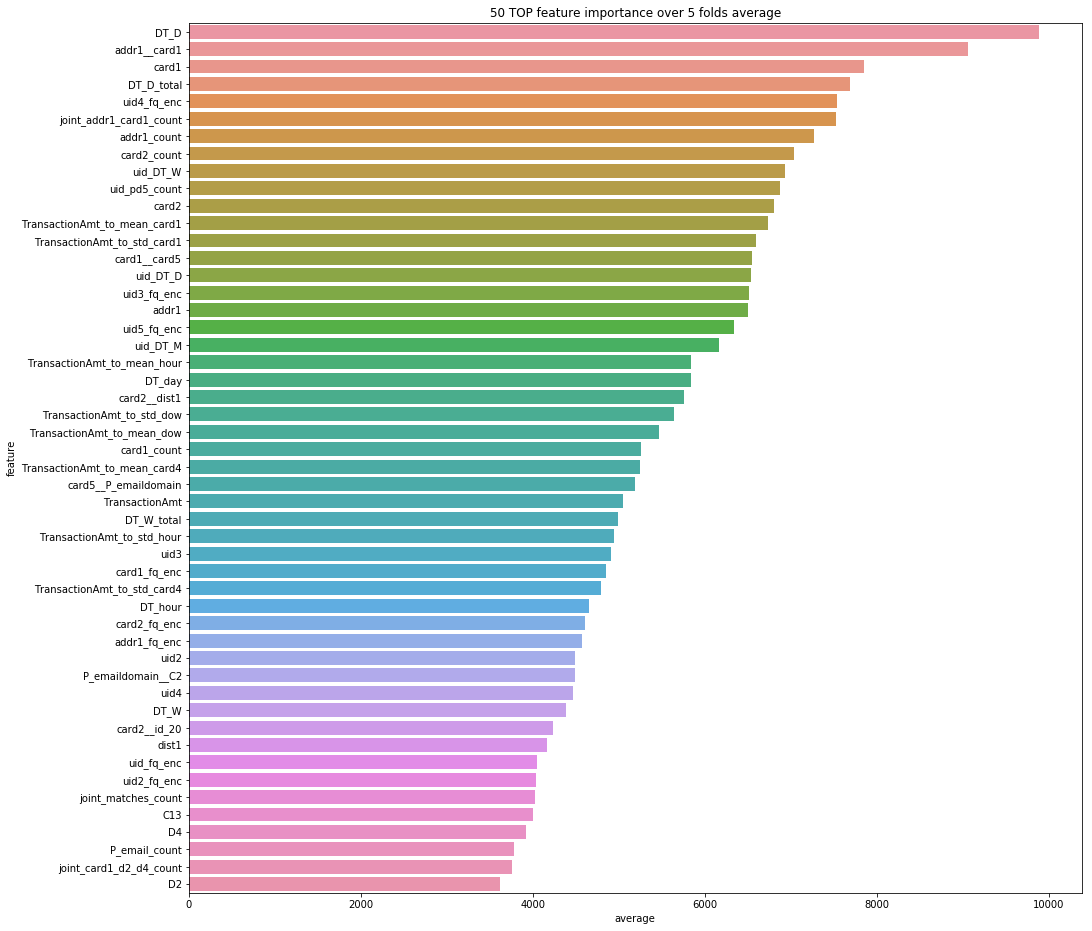

In [36]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [37]:
best_iter = clf.best_iteration

In [38]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, Y)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=2221, num_leaves=493,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

In [39]:
sub['isFraud'] = clf.predict_proba(X_test)[:, 1]

In [40]:
sub.to_csv('lightgbmdownsampled400k.csv', index=False)

I would like to thank my teammate Arda for his contributions, and all the competitors who shared kernels and their ideas. Any comment is much appreciated. If you own any codeblocks in this kernel, please don't hesitate to tell it in comments.